In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import numpy as np

from src.models import GraphSAGE, LinkPredictor
from src.data.gamma.arxiv import load_data, get_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.gamma import GammaGraphSage

In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [9]:
data = load_data()

data, edges_val, edges_test, neg_edges_val, neg_edges_test =\
    get_val_test_edges(data, remove_from_data=True, device=device)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

## Training

In [7]:
for run in range(30):
    gamma = GammaGraphSage(device, data.num_nodes, run=run)
    torch.cuda.empty_cache()
    gamma.train(edge_index,
                edges_val,
                edges_test,
                neg_edges_val,
                neg_edges_test,
                data.adj_t,
                data.y)

2022-04-24 20:02:27 - INFO : Run: 0000, Epoch: 0001, Train Loss: 1.3983, Valid loss: 1.1462, Test loss: 1.1484, Train AUC: 0.5829, Valid AUC: 0.5827, Test AUC: 0.5777
2022-04-24 20:02:34 - INFO : Run: 0000, Epoch: 0002, Train Loss: 1.0874, Valid loss: 1.0919, Test loss: 1.0924, Train AUC: 0.6073, Valid AUC: 0.6037, Test AUC: 0.5977
2022-04-24 20:02:40 - INFO : Run: 0000, Epoch: 0003, Train Loss: 1.0461, Valid loss: 1.0605, Test loss: 1.0612, Train AUC: 0.6244, Valid AUC: 0.6181, Test AUC: 0.6125
2022-04-24 20:02:47 - INFO : Run: 0000, Epoch: 0004, Train Loss: 1.0143, Valid loss: 1.0323, Test loss: 1.0333, Train AUC: 0.6375, Valid AUC: 0.6283, Test AUC: 0.6240
2022-04-24 20:02:53 - INFO : Run: 0000, Epoch: 0005, Train Loss: 0.9843, Valid loss: 1.0050, Test loss: 1.0059, Train AUC: 0.6438, Valid AUC: 0.6347, Test AUC: 0.6291
2022-04-24 20:02:59 - INFO : Run: 0000, Epoch: 0006, Train Loss: 0.9552, Valid loss: 0.9782, Test loss: 0.9796, Train AUC: 0.6515, Valid AUC: 0.6406, Test AUC: 0.635

## Results

In [10]:
gamma = GammaGraphSage(device, data.num_nodes, run=0)

In [11]:
metrics = gamma.read_metrics()
print(metrics.shape)
metrics.head()

(3030, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,None,1.626175,1.626175,0.510545,0.509700,0.513489
1,0,1,1.398262310423816,1.146235,1.148360,0.582897,0.582684,0.577722
2,0,2,1.0874286127417985,1.091925,1.092394,0.607321,0.603658,0.597680
3,0,3,1.0461019507120863,1.060525,1.061159,0.624413,0.618095,0.612511
4,0,4,1.014278989100601,1.032276,1.033293,0.637483,0.628344,0.623976


### Sumarize metrics per epoch

In [12]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [13]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [14]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,-1.000000,0.000000,1.626146,0.000037,1.626147,0.000037,0.507671,0.002183,0.506828,0.004435,0.506923,0.003984
1,1.394978,0.010148,1.158363,0.011093,1.160271,0.010630,0.609061,0.016504,0.605539,0.014850,0.599971,0.014782
2,1.090697,0.004232,1.092133,0.003124,1.094050,0.002991,0.627963,0.011031,0.621994,0.009839,0.615456,0.009369
3,1.044178,0.002363,1.057535,0.002581,1.059243,0.002601,0.636068,0.007457,0.628083,0.006609,0.622171,0.006456
4,1.011102,0.002223,1.028446,0.002558,1.029756,0.002830,0.644727,0.005404,0.635193,0.005073,0.629668,0.004860


In [90]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
18,0.690470,0.001914,0.740716,0.001721,0.741199,0.001705,0.679403,0.000895,0.669902,0.001172,0.663274,0.001184
17,0.707079,0.001914,0.755276,0.001730,0.755721,0.001769,0.679438,0.000853,0.669836,0.000953,0.663129,0.001025
16,0.724523,0.002035,0.770561,0.001786,0.770939,0.001878,0.679558,0.000904,0.669700,0.001097,0.662969,0.001236
15,0.742696,0.002016,0.786556,0.001796,0.786997,0.002000,0.679594,0.001092,0.669489,0.001243,0.662808,0.001389
19,0.674396,0.001942,0.726819,0.001756,0.727296,0.001696,0.678637,0.000939,0.669334,0.001092,0.662783,0.001102


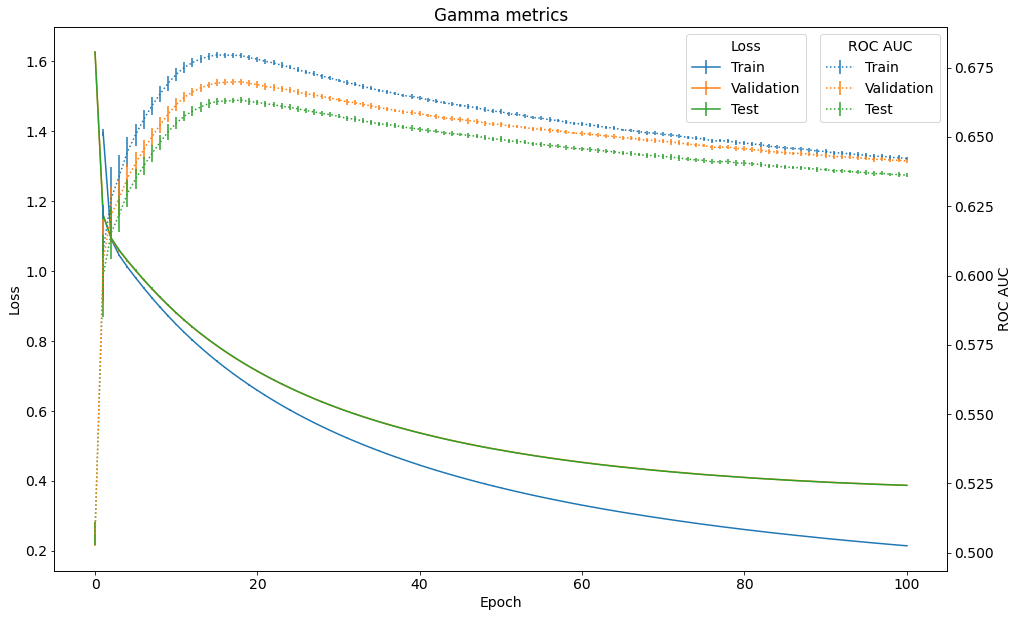

In [87]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Gamma metrics')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='upper right', title='Loss', bbox_to_anchor=[0.85, 1])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='upper right', title='ROC AUC', bbox_to_anchor=[1, 1])
ax2.set_ylabel('ROC AUC')

plt.savefig('reports/images/gamma_training_metrics.svg')